In [1]:
from google.colab import drive
drive.mount('/content/drive')

DATASET_ROOT = "/content/drive/MyDrive/dataset-multimodal"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import Library

In [2]:
!pip install -q panns-inference transformers pretty_midi mido librosa seaborn

import os
import numpy as np
import pandas as pd
from tqdm import tqdm

import librosa
import pretty_midi
from mido import MidiFile

import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE

# Audio model (PANNs)
from panns_inference import AudioTagging

# Lyrics model (BERT)
from transformers import BertTokenizer, BertModel

# MIDI model (ResNet18)
import torchvision.models as models
import torchvision.transforms as T

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


Jumlah baris categories: 903
Jumlah baris clusters  : 903
Jumlah file audio: 903


,file_id,category,cluster
0,001,Boisterous,Cluster 1
1,002,Boisterous,Cluster 1
2,003,Boisterous,Cluster 1
3,004,Boisterous,Cluster 1
4,005,Boisterous,Cluster 1



Distribusi kategori:


,count
category,
Passionate,40
Literate,39
Campy,38
Bittersweet,38
Confident,37
Wry,37
Brooding,36
Autumnal,36
Amiable-good natured,35



Distribusi cluster:


,count
cluster,
Cluster 3,215
Cluster 4,191
Cluster 1,170
Cluster 2,164
Cluster 5,163


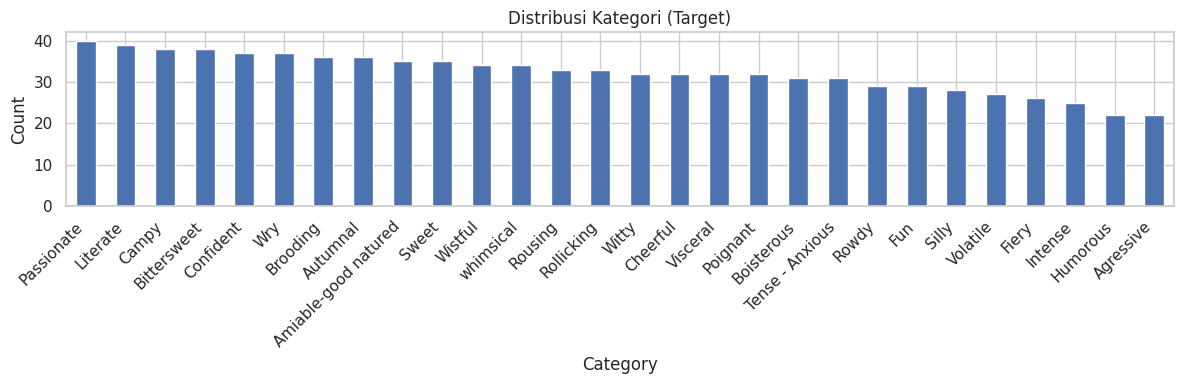

In [3]:
def read_label_file(path_no_ext):
    """Coba baca <path_no_ext> atau <path_no_ext>.txt."""
    if os.path.exists(path_no_ext):
        path = path_no_ext
    elif os.path.exists(path_no_ext + ".txt"):
        path = path_no_ext + ".txt"
    else:
        raise FileNotFoundError(f"File label tidak ditemukan: {path_no_ext}(.txt)")
    with open(path, "r", encoding="utf-8") as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

categories = read_label_file(os.path.join(DATASET_ROOT, "categories"))
clusters   = read_label_file(os.path.join(DATASET_ROOT, "clusters"))

print("Jumlah baris categories:", len(categories))
print("Jumlah baris clusters  :", len(clusters))

assert len(categories) == len(clusters), "Panjang categories dan clusters harus sama"

# pakai daftar audio sebagai acuan urutan
audio_dir = os.path.join(DATASET_ROOT, "Audio")
audio_files = sorted([f for f in os.listdir(audio_dir) if f.lower().endswith(".mp3")])
audio_ids = [os.path.splitext(f)[0] for f in audio_files]

print("Jumlah file audio:", len(audio_ids))
assert len(audio_ids) == len(categories), "Jumlah audio != jumlah baris label"

labels_df = pd.DataFrame({
    "file_id": audio_ids,
    "category": categories,
    "cluster": clusters
})

display(labels_df.head())

print("\nDistribusi kategori:")
display(labels_df["category"].value_counts())

print("\nDistribusi cluster:")
display(labels_df["cluster"].value_counts())

plt.figure(figsize=(12, 4))
labels_df["category"].value_counts().plot(kind="bar")
plt.title("Distribusi Kategori (Target)")
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## Helper Function

In [4]:
def plot_hist(df, col, title, xlabel):
    plt.figure()
    plt.hist(df[col].dropna(), bins=30, edgecolor="black", alpha=0.8)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Frequency")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def tsne_and_scatter(X, labels, title, random_state=42):
    """
    X      : np.array [N, D]
    labels : list / Series panjang N
    """
    if X.shape[0] < 5:
        print("Data terlalu sedikit untuk t-SNE.")
        return None

    perplexity = min(30, max(5, X.shape[0] // 4))
    print(f"Running t-SNE: n_samples={X.shape[0]}, dim={X.shape[1]}, perplexity={perplexity}")

    tsne = TSNE(
        n_components=2,
        random_state=random_state,
        perplexity=perplexity,
        max_iter=1000
    )
    X_2d = tsne.fit_transform(X)

    labels = pd.Series(labels).astype(str)
    uniq = labels.unique()
    cmap = plt.cm.get_cmap("tab20", len(uniq))

    plt.figure(figsize=(8, 6))
    for i, lab in enumerate(uniq):
        mask = (labels == lab).values
        plt.scatter(
            X_2d[mask, 0],
            X_2d[mask, 1],
            s=40,
            alpha=0.7,
            label=lab,
            color=cmap(i)
        )
    plt.title(title)
    plt.xlabel("t-SNE dim 1")
    plt.ylabel("t-SNE dim 2")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    return X_2d

# cek file korup
def check_audio_ok(path):
    try:
        _y, _sr = librosa.load(path, sr=None, mono=True)
        return True
    except Exception:
        return False

def check_lyrics_ok(path):
    try:
        with open(path, "r", encoding="utf-8") as f:
            _ = f.read()
        return True
    except Exception:
        return False

def check_midi_ok(path):
    try:
        _ = MidiFile(path)
        return True
    except Exception:
        return False

def zscore_np(x):
    m = x.mean(axis=0, keepdims=True)
    s = x.std(axis=0, keepdims=True) + 1e-8
    return (x - m) / s

## AUDIO

Dataset audio berisi 903 file .mp3 berdurasi ±30 detik, masing-masing merepresentasikan potongan lagu dalam bentuk sinyal suara asli.

### Cek File dan Fitur Mentah

Total audio files found: 903


Checking audio files: 100%|██████████| 903/903 [03:48<00:00,  3.95it/s]


Corrupt audio files: 0


Extracting audio stats: 100%|██████████| 903/903 [06:21<00:00,  2.37it/s]

Audio stats shape: (903, 6)


,file_id,duration_audio,tempo,zcr,spectral_centroid,rms_energy
0,001,29.628662,[60.799632352941174],0.096978,3591.478661,0.124067
1,002,29.582222,[156.60511363636363],0.024919,1726.221489,0.093081
2,003,29.767982,[105.46875],0.058417,2591.292266,0.135723
3,004,29.675102,[95.703125],0.088290,2967.550972,0.173973
4,005,28.885624,[101.33272058823529],0.066502,2675.267259,0.117730


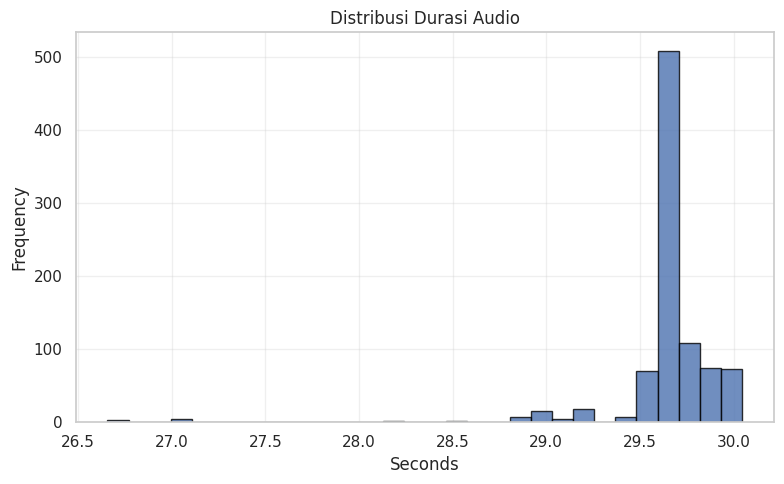

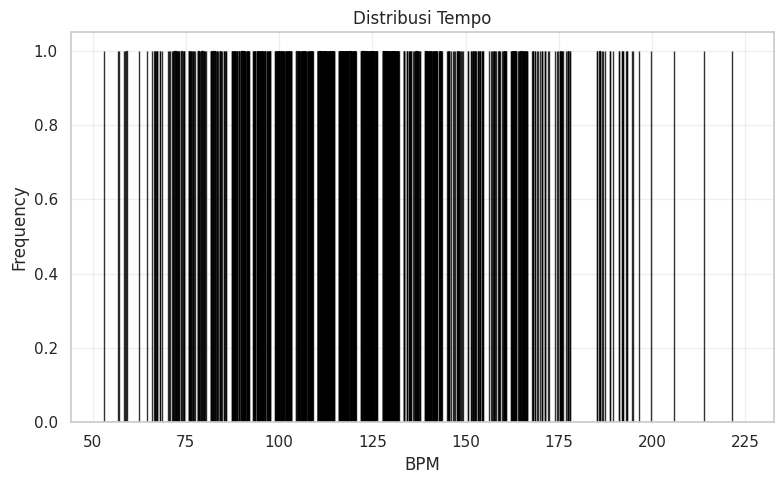

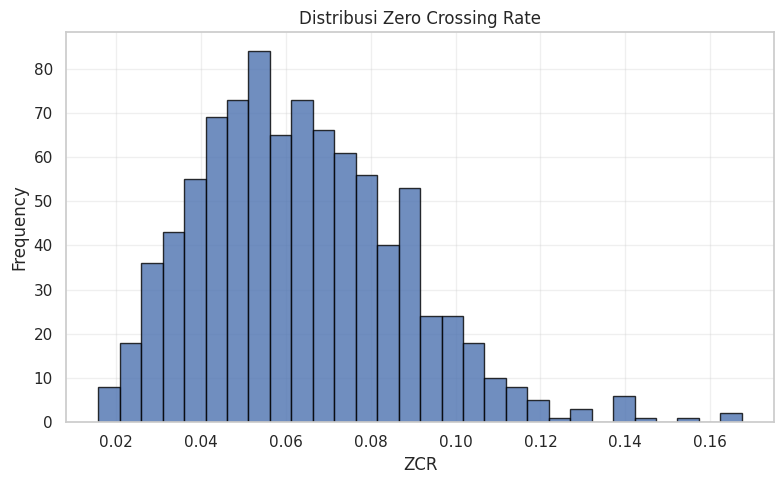

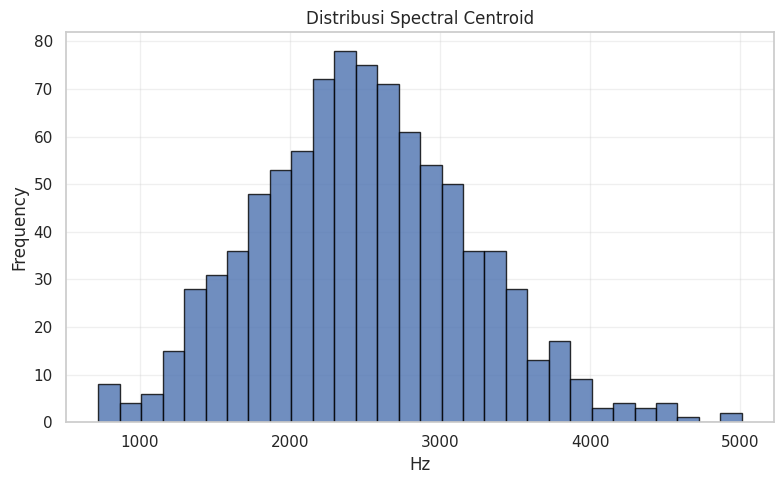

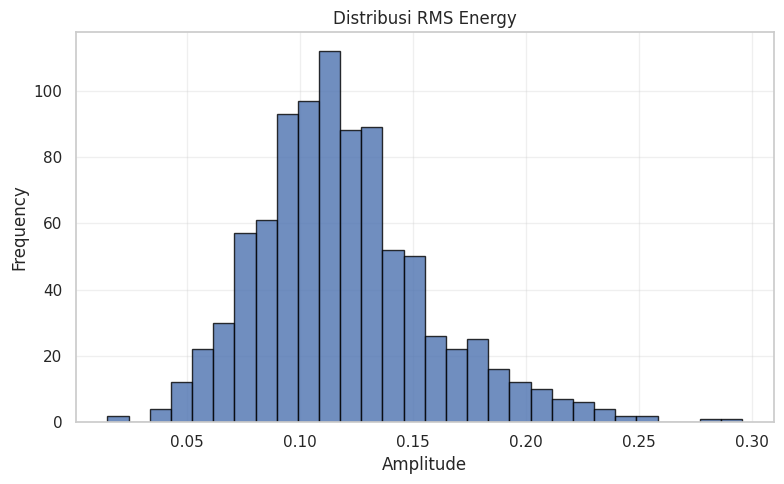

In [5]:
audio_dir = os.path.join(DATASET_ROOT, "Audio")
audio_files = sorted([f for f in os.listdir(audio_dir) if f.lower().endswith(".mp3")])
print("Total audio files found:", len(audio_files))

audio_meta = []
corrupt_audio = []

for f in tqdm(audio_files, desc="Checking audio files"):
    path = os.path.join(audio_dir, f)
    file_id = os.path.splitext(f)[0]
    ok = check_audio_ok(path)
    if not ok:
        corrupt_audio.append(file_id)
    audio_meta.append({
        "file_id": file_id,
        "file_name": f,
        "audio_ok": ok
    })

audio_df = pd.DataFrame(audio_meta)
print("Corrupt audio files:", len(corrupt_audio))
if corrupt_audio:
    print("Example corrupt:", corrupt_audio[:10])

# fitur: durasi, tempo, zcr, spectral centroid, rms
audio_stats = []
for f in tqdm(audio_files, desc="Extracting audio stats"):
    file_id = os.path.splitext(f)[0]
    if file_id in corrupt_audio:
        continue
    path = os.path.join(audio_dir, f)
    try:
        y, sr = librosa.load(path, sr=None, mono=True)
        duration = librosa.get_duration(y=y, sr=sr)
        tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)[0].mean()
        centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0].mean()
        rms = librosa.feature.rms(y=y)[0].mean()

        audio_stats.append({
            "file_id": file_id,
            "duration_audio": duration,
            "tempo": tempo,
            "zcr": zcr,
            "spectral_centroid": centroid,
            "rms_energy": rms
        })
    except Exception:
        corrupt_audio.append(file_id)

audio_stats_df = pd.DataFrame(audio_stats)
print("Audio stats shape:", audio_stats_df.shape)
display(audio_stats_df.head())

plot_hist(audio_stats_df, "duration_audio", "Distribusi Durasi Audio", "Seconds")
plot_hist(audio_stats_df, "tempo", "Distribusi Tempo", "BPM")
plot_hist(audio_stats_df, "zcr", "Distribusi Zero Crossing Rate", "ZCR")
plot_hist(audio_stats_df, "spectral_centroid", "Distribusi Spectral Centroid", "Hz")
plot_hist(audio_stats_df, "rms_energy", "Distribusi RMS Energy", "Amplitude")

Distribusi Durasi

Histogram durasi audio menunjukkan bahwa hampir seluruh file memiliki panjang yang sangat konsisten di kisaran 29.5–30 detik. Hal ini sangat menguntungkan karena proses standardisasi panjang sinyal menjadi sederhana: pad/trim ke 30 detik.

Fitur Spektral (ZCR, Spectral Centroid, RMS)

Distribusi ZCR, centroid, dan RMS menunjukkan pola yang normal tanpa outlier ekstrem. Hal ini mengindikasikan kualitas audio yang stabil dan tidak terdapat file dengan karakteristik spektral yang menyimpang.

Estimasi Tempo

Plot tempo menunjukkan hasil yang sangat noisy dan acak. Estimasi tempo dari librosa.beat_track tidak dapat diandalkan pada dataset multi-genre ini, sehingga EDA menyimpulkan bahwa tempo tidak digunakan sebagai fitur eksplisit.

### PANNs CNN14 + t-SNE

Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
GPU number: 1
✓ PANNs CNN14 loaded


Extracting audio embeddings (CNN14): 100%|██████████| 903/903 [02:08<00:00,  7.05it/s]


Audio embeddings (CNN14) shape: (903, 2049)


,file_id,audio_emb_0,audio_emb_1,audio_emb_2,audio_emb_3,audio_emb_4,audio_emb_5,audio_emb_6,audio_emb_7,audio_emb_8,...,audio_emb_2038,audio_emb_2039,audio_emb_2040,audio_emb_2041,audio_emb_2042,audio_emb_2043,audio_emb_2044,audio_emb_2045,audio_emb_2046,audio_emb_2047
0,001,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
1,002,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.042250,0.148037,1.200101,0.0
2,003,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.167546,0.000000,0.0
3,004,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.681438,0.132550,0.000000,0.0
4,005,0.0,0.387401,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.508791,0.168468,0.000000,0.0


Audio + labels: (903, 2056)


,file_id,duration_audio,tempo,zcr,spectral_centroid,rms_energy,audio_emb_0,audio_emb_1,audio_emb_2,audio_emb_3,...,audio_emb_2040,audio_emb_2041,audio_emb_2042,audio_emb_2043,audio_emb_2044,audio_emb_2045,audio_emb_2046,audio_emb_2047,category,cluster
0,001,29.628662,[60.799632352941174],0.096978,3591.478661,0.124067,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,Boisterous,Cluster 1
1,002,29.582222,[156.60511363636363],0.024919,1726.221489,0.093081,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.042250,0.148037,1.200101,0.0,Boisterous,Cluster 1
2,003,29.767982,[105.46875],0.058417,2591.292266,0.135723,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.167546,0.000000,0.0,Boisterous,Cluster 1
3,004,29.675102,[95.703125],0.088290,2967.550972,0.173973,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.681438,0.132550,0.000000,0.0,Boisterous,Cluster 1
4,005,28.885624,[101.33272058823529],0.066502,2675.267259,0.117730,0.0,0.387401,0.0,0.0,...,0.0,0.0,0.0,0.0,0.508791,0.168468,0.000000,0.0,Boisterous,Cluster 1


Running t-SNE: n_samples=903, dim=2048, perplexity=30


/tmp/ipython-input-782246349.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(uniq))


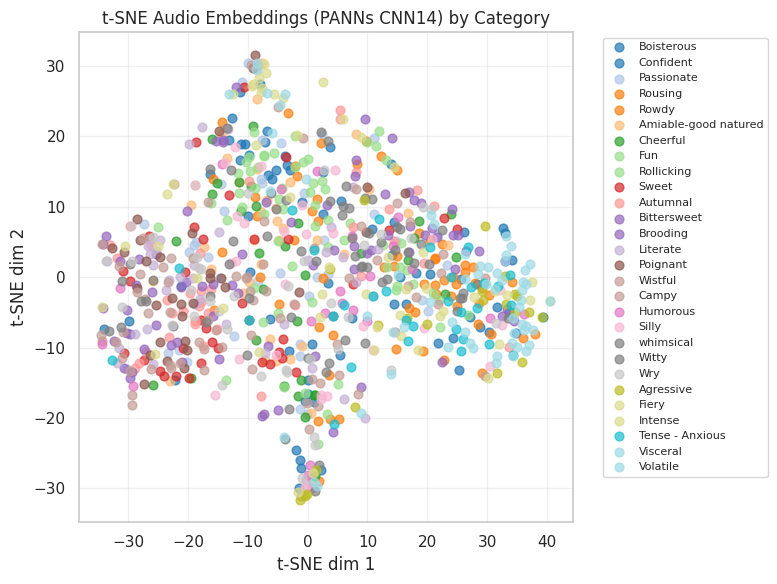

In [13]:
from panns_inference import AudioTagging

# 1) Load model PANNs CNN14 (pretrained)
at_model = AudioTagging(checkpoint_path=None, device=device)
print("✓ PANNs CNN14 loaded")

def extract_audio_embedding(path, model, target_sr=32000, seconds=30):
    """
    Ekstrak embedding CNN14 untuk 1 file audio full.
    - Resample ke target_sr (default 32 kHz)
    - Trim/pad ke 'seconds' detik
    - Kembalikan vektor embedding (2048-dim)
    """
    y, sr = librosa.load(path, sr=target_sr, mono=True)
    max_len = target_sr * seconds

    if len(y) < max_len:
        y = np.pad(y, (0, max_len - len(y)))
    else:
        y = y[:max_len]

    x = y[None, :]  # shape: (1, n_samples)
    with torch.no_grad():
        _, embedding = model.inference(x)  # embedding: [1, 2048]
    return embedding[0]  # (2048,)


# 2) Ekstrak embedding untuk semua audio yang tidak korup
audio_emb_records = []

for f in tqdm(audio_files, desc="Extracting audio embeddings (CNN14)"):
    file_id = os.path.splitext(f)[0]
    if file_id in corrupt_audio:
        continue

    path = os.path.join(audio_dir, f)
    try:
        emb = extract_audio_embedding(path, at_model)
        row = {"file_id": file_id}
        for i, v in enumerate(emb):
            row[f"audio_emb_{i}"] = float(v)
        audio_emb_records.append(row)
    except Exception as e:
        print("Error embedding", f, ":", e)

audio_emb_df = pd.DataFrame(audio_emb_records)
print("Audio embeddings (CNN14) shape:", audio_emb_df.shape)
display(audio_emb_df.head())

# 3) Gabung dengan fitur mentah + label
audio_full = (
    audio_stats_df
      .merge(audio_emb_df, on="file_id", how="inner")
      .merge(labels_df,   on="file_id", how="left")
)

print("Audio + labels:", audio_full.shape)
display(audio_full.head())

# 4) t-SNE embedding audio per kategori
audio_emb_cols = [c for c in audio_full.columns if c.startswith("audio_emb_")]
X_audio = audio_full[audio_emb_cols].values
y_audio = audio_full["category"].fillna("Unknown")

audio_tsne = tsne_and_scatter(
    X_audio,
    y_audio,
    title="t-SNE Audio Embeddings (PANNs CNN14) by Category"
)

Hasil t-SNE pada embedding audio menunjukkan adanya pola penyebaran yang membentuk beberapa kelompok besar, namun kategori emosi masih saling tumpang-tindih. Hal ini menunjukkan bahwa representasi CNN14 berhasil menangkap karakter akustik secara umum, tetapi audio saja belum cukup kuat untuk memisahkan kategori emosi secara jelas pada ruang berdimensi rendah.

## LIRIK

Dataset lirik terdiri dari 764 file .txt yang berisi teks lengkap dari lagu dengan nama file yang disesuaikan dengan ID audio. Lirik ini menyediakan informasi semantik yang tidak muncul pada sinyal audio.

### Cek File dan Fitur Mentah

Total lyrics files found: 764


Checking lyrics files: 100%|██████████| 764/764 [00:12<00:00, 59.38it/s] 


Corrupt lyrics files: 0


Extracting lyrics stats: 100%|██████████| 764/764 [00:01<00:00, 443.93it/s]

Lyrics stats shape: (764, 5)


,file_id,word_count,char_count,line_count,avg_word_length
0,001,167,907,28,4.239521
1,003,260,1321,33,4.065385
2,004,232,1157,52,3.758621
3,007,426,2073,65,3.819249
4,008,122,642,18,4.098361


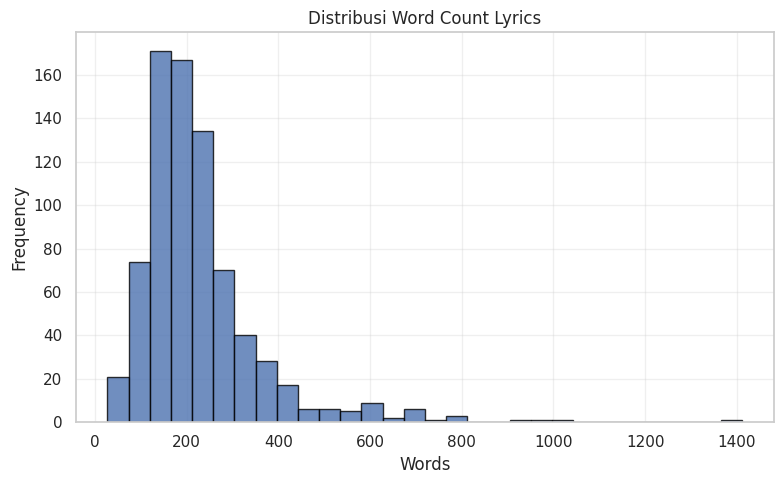

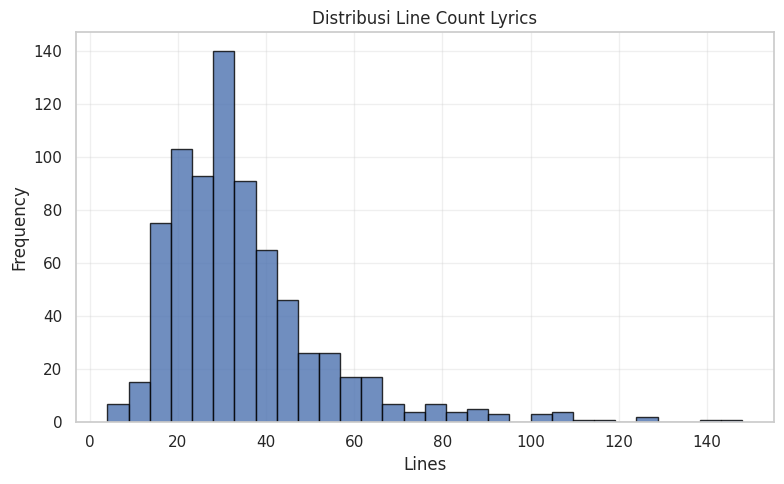

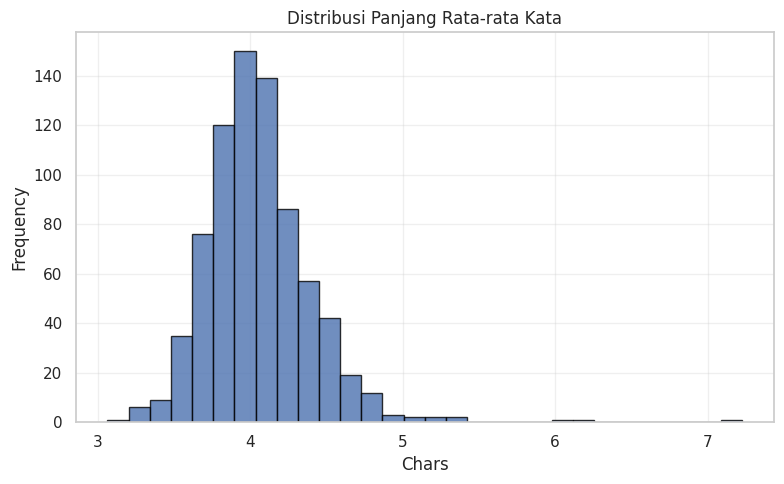

In [7]:
lyrics_dir = os.path.join(DATASET_ROOT, "Lyrics")
lyrics_files = sorted([f for f in os.listdir(lyrics_dir) if f.lower().endswith(".txt")])
print("Total lyrics files found:", len(lyrics_files))

lyrics_meta = []
corrupt_lyrics = []

for f in tqdm(lyrics_files, desc="Checking lyrics files"):
    path = os.path.join(lyrics_dir, f)
    file_id = os.path.splitext(f)[0]
    ok = check_lyrics_ok(path)
    if not ok:
        corrupt_lyrics.append(file_id)
    lyrics_meta.append({
        "file_id": file_id,
        "file_name": f,
        "lyrics_ok": ok
    })

lyrics_df = pd.DataFrame(lyrics_meta)
print("Corrupt lyrics files:", len(corrupt_lyrics))

lyrics_stats = []
for f in tqdm(lyrics_files, desc="Extracting lyrics stats"):
    file_id = os.path.splitext(f)[0]
    if file_id in corrupt_lyrics:
        continue
    path = os.path.join(lyrics_dir, f)
    try:
        with open(path, "r", encoding="utf-8") as fh:
            text = fh.read().strip()
        if not text:
            continue
        words = text.split()
        lines = text.split("\n")
        word_count = len(words)
        char_count = len(text)
        line_count = len([ln for ln in lines if ln.strip()])
        avg_word_len = np.mean([len(w) for w in words]) if words else 0.0

        lyrics_stats.append({
            "file_id": file_id,
            "word_count": word_count,
            "char_count": char_count,
            "line_count": line_count,
            "avg_word_length": avg_word_len
        })
    except Exception:
        corrupt_lyrics.append(file_id)

lyrics_stats_df = pd.DataFrame(lyrics_stats)
print("Lyrics stats shape:", lyrics_stats_df.shape)
display(lyrics_stats_df.head())

plot_hist(lyrics_stats_df, "word_count", "Distribusi Word Count Lyrics", "Words")
plot_hist(lyrics_stats_df, "line_count", "Distribusi Line Count Lyrics", "Lines")
plot_hist(lyrics_stats_df, "avg_word_length", "Distribusi Panjang Rata-rata Kata", "Chars")

Distribusi Word Count, Line Count, dan Panjang Kata

Mayoritas lirik memiliki sekitar 150–350 kata, dengan beberapa outlier sangat panjang hingga >1000 kata. Line count juga konsisten di kisaran 20–45 baris. Hal ini berarti:

- Lirik cukup panjang untuk memberikan konteks semantik

- Tetapi perlu ada pembatasan max_length saat menggunakan BERT untuk mencegah pemotongan berlebihan

Struktur lirik konsisten seperti lirik musik pada umumnya, sehingga tidak membutuhkan pembersihan mendalam atau normalisasi struktur.

### BERT Embedding dan t-SNE

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

✓ BERT loaded: bert-base-uncased


Extracting lyrics embeddings: 100%|██████████| 764/764 [00:16<00:00, 46.21it/s]


Lyrics embeddings shape: (764, 769)
Lyrics + labels: (764, 775)


,file_id,word_count,char_count,line_count,avg_word_length,lyrics_emb_0,lyrics_emb_1,lyrics_emb_2,lyrics_emb_3,lyrics_emb_4,...,lyrics_emb_760,lyrics_emb_761,lyrics_emb_762,lyrics_emb_763,lyrics_emb_764,lyrics_emb_765,lyrics_emb_766,lyrics_emb_767,category,cluster
0,001,167,907,28,4.239521,-0.091757,0.222423,0.286721,-0.209977,0.151715,...,-0.130137,-0.200832,-0.219145,-0.148372,0.072174,-0.202672,0.131236,0.028708,Boisterous,Cluster 1
1,003,260,1321,33,4.065385,-0.110028,-0.008697,0.284779,0.009259,0.272160,...,-0.157859,-0.298056,-0.194951,-0.119922,-0.012017,-0.090214,0.286724,-0.031385,Boisterous,Cluster 1
2,004,232,1157,52,3.758621,0.257812,-0.101870,0.455210,-0.173756,0.056749,...,-0.061472,-0.310333,-0.032488,-0.280330,-0.129321,-0.108299,-0.135520,0.120111,Boisterous,Cluster 1
3,007,426,2073,65,3.819249,0.143314,-0.073447,0.211989,0.008507,0.270988,...,0.051771,-0.206817,-0.237255,-0.082366,-0.099564,-0.193938,0.069740,0.051778,Boisterous,Cluster 1
4,008,122,642,18,4.098361,0.073305,0.111060,0.235955,-0.105091,0.211663,...,0.049307,-0.156077,-0.193034,-0.364083,-0.049050,-0.207436,-0.066910,-0.047215,Boisterous,Cluster 1


Running t-SNE: n_samples=764, dim=768, perplexity=30


/tmp/ipython-input-782246349.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(uniq))


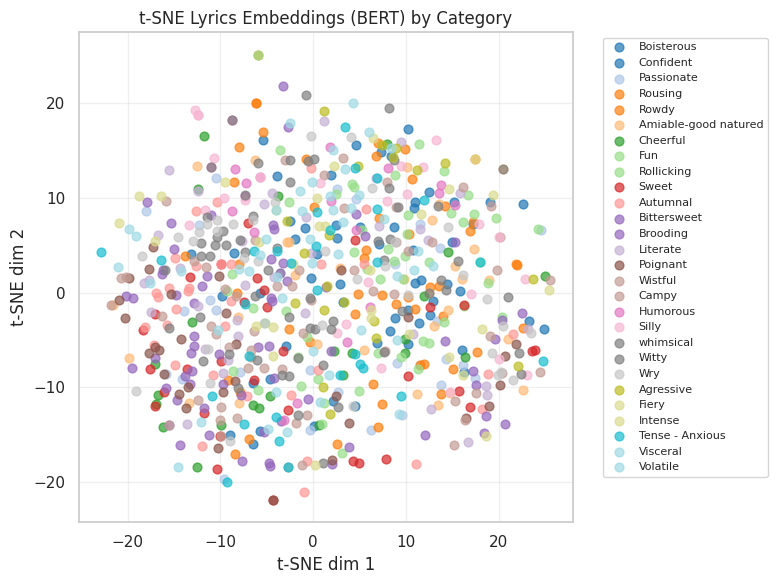

In [8]:
bert_model_name = "bert-base-uncased"   # ganti kalau mau IndoBERT
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
bert_model = BertModel.from_pretrained(bert_model_name).to(device)
bert_model.eval()
print("✓ BERT loaded:", bert_model_name)

def get_bert_embedding(text, tokenizer, model, max_len=256):
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=max_len
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    hidden = outputs.last_hidden_state        # [1, L, H]
    mask = inputs["attention_mask"].unsqueeze(-1)
    masked = hidden * mask
    sum_hidden = masked.sum(dim=1)
    sum_mask = mask.sum(dim=1)
    mean_pooled = sum_hidden / sum_mask
    return mean_pooled.squeeze(0).cpu().numpy()   # (H,)

lyrics_emb_records = []
for f in tqdm(lyrics_files, desc="Extracting lyrics embeddings"):
    file_id = os.path.splitext(f)[0]
    if file_id in corrupt_lyrics:
        continue
    path = os.path.join(lyrics_dir, f)
    try:
        with open(path, "r", encoding="utf-8") as fh:
            text = fh.read().strip()
        if not text:
            continue
        emb = get_bert_embedding(text, tokenizer, bert_model)
        row = {"file_id": file_id}
        for i, v in enumerate(emb):
            row[f"lyrics_emb_{i}"] = float(v)
        lyrics_emb_records.append(row)
    except Exception as e:
        print("Error embedding lyrics", f, ":", e)

lyrics_emb_df = pd.DataFrame(lyrics_emb_records)
print("Lyrics embeddings shape:", lyrics_emb_df.shape)

lyrics_full = (
    lyrics_stats_df
      .merge(lyrics_emb_df, on="file_id", how="inner")
      .merge(labels_df, on="file_id", how="left")
)
print("Lyrics + labels:", lyrics_full.shape)
display(lyrics_full.head())

lyrics_emb_cols = [c for c in lyrics_full.columns if c.startswith("lyrics_emb_")]
X_lyrics = lyrics_full[lyrics_emb_cols].values
y_lyrics = lyrics_full["category"].fillna("Unknown")

lyrics_tsne = tsne_and_scatter(
    X_lyrics, y_lyrics,
    title="t-SNE Lyrics Embeddings (BERT) by Category"
)

Berdasarkan hasil t-SNE pada embedding BERT di dataset ini, representasi lirik tidak membentuk cluster yang selaras dengan kategori emosi yang digunakan. Hal ini disebabkan karena kategori emosi dalam dataset lebih bersifat akustik (berdasarkan karakter suara dan mood musikal) daripada semantik, sehingga lirik tidak menjadi penentu utama. Selain itu, reduksi dimensi melalui t-SNE menyebabkan informasi semantik halus tidak tampak secara visual.

## MIDI

Dataset MIDI mencakup 196 file .mid yang merepresentasikan struktur musik secara simbolis, seperti nada dan ritme.

### Cek File dan Fitur Mentah

Total MIDI files found: 196


Checking MIDI files: 100%|██████████| 196/196 [00:22<00:00,  8.66it/s]


Corrupt MIDI files: 2


Extracting MIDI stats: 100%|██████████| 196/196 [00:58<00:00,  3.34it/s]

MIDI stats shape: (194, 7)


,file_id,duration_midi,n_tracks,min_pitch,max_pitch,pitch_range,avg_velocity
0,004,230.458718,22,28,91,63,117.386846
1,008,267.857000,3,40,73,33,126.945980
2,012,280.470035,8,28,84,56,91.172080
3,019,249.595000,7,31,91,60,113.399088
4,020,138.923494,13,11,103,92,105.848546


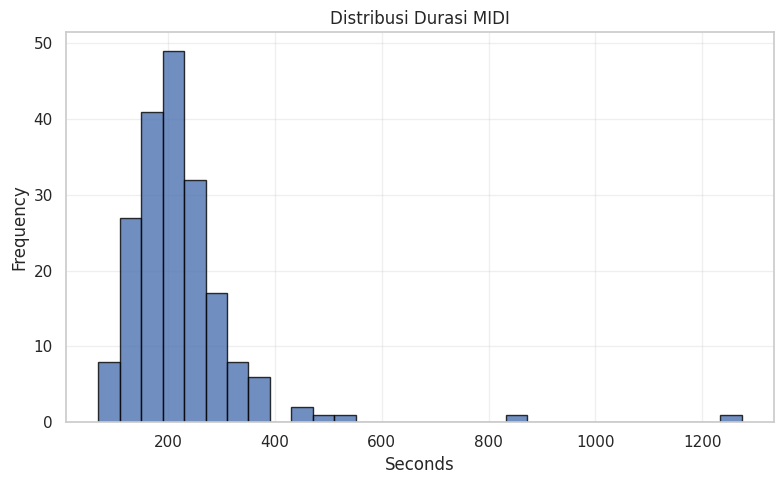

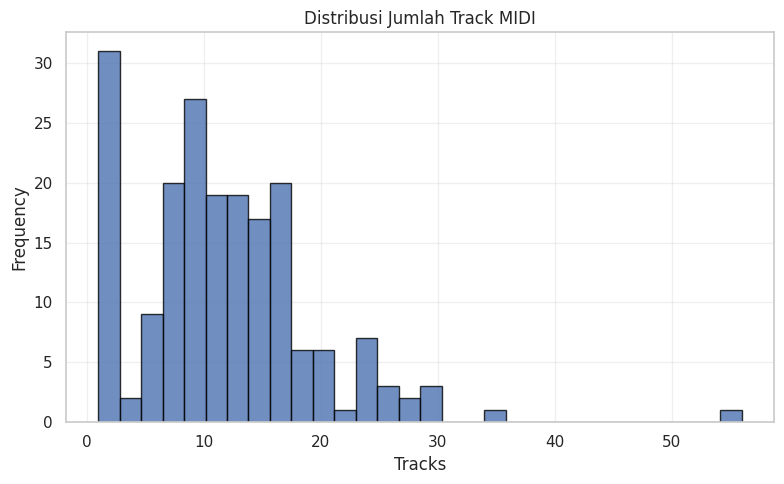

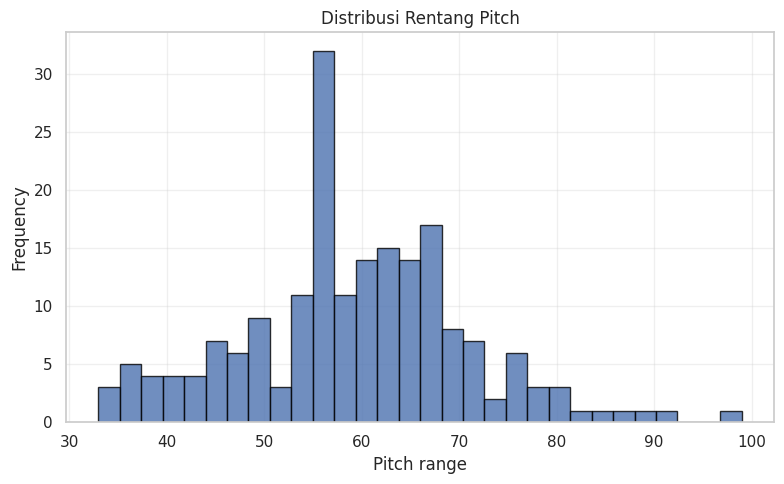

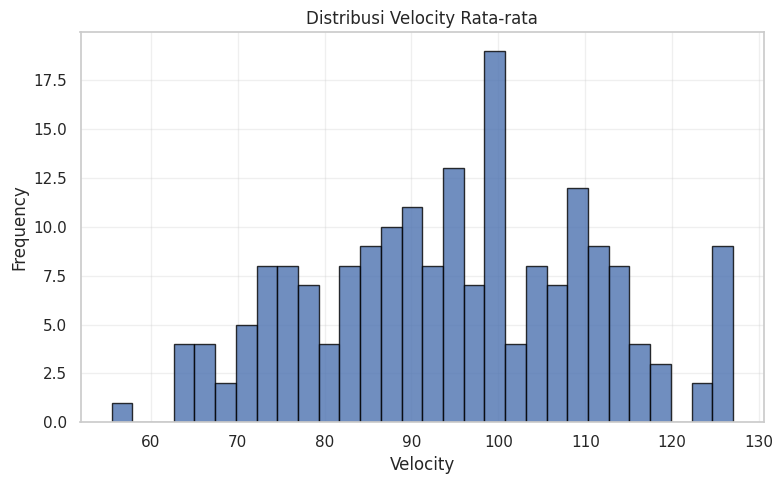

In [9]:
midi_dir = os.path.join(DATASET_ROOT, "MIDIs")
midi_files = sorted([f for f in os.listdir(midi_dir) if f.lower().endswith(".mid")])
print("Total MIDI files found:", len(midi_files))

midi_meta = []
corrupt_midi = []

for f in tqdm(midi_files, desc="Checking MIDI files"):
    path = os.path.join(midi_dir, f)
    file_id = os.path.splitext(f)[0]
    ok = check_midi_ok(path)
    if not ok:
        corrupt_midi.append(file_id)
    midi_meta.append({
        "file_id": file_id,
        "file_name": f,
        "midi_ok": ok
    })

midi_df = pd.DataFrame(midi_meta)
print("Corrupt MIDI files:", len(corrupt_midi))

midi_stats = []
for f in tqdm(midi_files, desc="Extracting MIDI stats"):
    file_id = os.path.splitext(f)[0]
    if file_id in corrupt_midi:
        continue
    path = os.path.join(midi_dir, f)
    try:
        mid = MidiFile(path)
        duration = mid.length
        n_tracks = len(mid.tracks)

        notes = []
        velocities = []
        for track in mid.tracks:
            for msg in track:
                if msg.type == "note_on" and msg.velocity > 0:
                    notes.append(msg.note)
                    velocities.append(msg.velocity)

        if len(notes) == 0:
            min_pitch = max_pitch = pitch_range = 0
        else:
            min_pitch = int(np.min(notes))
            max_pitch = int(np.max(notes))
            pitch_range = max_pitch - min_pitch

        avg_vel = float(np.mean(velocities)) if len(velocities) > 0 else 0.0

        midi_stats.append({
            "file_id": file_id,
            "duration_midi": duration,
            "n_tracks": n_tracks,
            "min_pitch": min_pitch,
            "max_pitch": max_pitch,
            "pitch_range": pitch_range,
            "avg_velocity": avg_vel
        })
    except Exception:
        corrupt_midi.append(file_id)

midi_stats_df = pd.DataFrame(midi_stats)
print("MIDI stats shape:", midi_stats_df.shape)
display(midi_stats_df.head())

plot_hist(midi_stats_df, "duration_midi", "Distribusi Durasi MIDI", "Seconds")
plot_hist(midi_stats_df, "n_tracks", "Distribusi Jumlah Track MIDI", "Tracks")
plot_hist(midi_stats_df, "pitch_range", "Distribusi Rentang Pitch", "Pitch range")
plot_hist(midi_stats_df, "avg_velocity", "Distribusi Velocity Rata-rata", "Velocity")

Ditemukan bahwa terdapat 2 file MIDI yang corrupt. Untuk menjaga konsistensi data dan mencegah error pada tahap pemrosesan selanjutnya, file-file MIDI yang corrupt tersebut akan dikeluarkan (exclude) dari dataset.

Durasi MIDI

Durasi MIDI jauh lebih bervariasi dibandingkan audio, berkisar antara 150 hingga >1200 detik. Ini merupakan temuan penting, karena representasi MIDI (piano-roll) akan menjadi sangat panjang dan tidak sebanding antar sampel jika tidak distandardisasi.

Jumlah Track

Banyak file memiliki 5–20 track, tetapi terdapat juga MIDI kompleks dengan >50 track. Hal ini menunjukkan dataset MIDI sangat heterogen dari sisi instrumen dan aransemen.

Rentang Pitch & Velocity

Distribusi pitch range (50–70) dan average velocity (70–115) cukup konsisten, menandakan perbedaan utama dari MIDI bukan terletak pada pitch/velocity, tetapi durasi dan kompleksitas.

### Resnet Embedding dan t-SNE

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:01<00:00, 30.9MB/s]


✓ ResNet18 ready for MIDI embeddings


Extracting MIDI embeddings:   0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/pretty_midi/pretty_midi.py:122: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
Extracting MIDI embeddings: 100%|██████████| 196/196 [00:39<00:00,  4.92it/s]

MIDI embeddings shape: (194, 513)
MIDI + labels: (194, 521)


,file_id,duration_midi,n_tracks,min_pitch,max_pitch,pitch_range,avg_velocity,midi_emb_0,midi_emb_1,midi_emb_2,...,midi_emb_504,midi_emb_505,midi_emb_506,midi_emb_507,midi_emb_508,midi_emb_509,midi_emb_510,midi_emb_511,category,cluster
0,004,230.458718,22,28,91,63,117.386846,1.008491,0.0,0.714603,...,0.0,0.440808,2.438327,1.115871,0.264604,1.542620,0.332262,0.048029,Boisterous,Cluster 1
1,008,267.857000,3,40,73,33,126.945980,1.884996,0.0,1.205792,...,0.0,0.329122,2.388682,1.199804,0.085526,2.059542,0.376692,0.092912,Boisterous,Cluster 1
2,012,280.470035,8,28,84,56,91.172080,0.959268,0.0,0.640258,...,0.0,0.453686,1.120349,1.094212,0.455733,1.102295,0.680130,0.064255,Boisterous,Cluster 1
3,019,249.595000,7,31,91,60,113.399088,1.159028,0.0,0.574192,...,0.0,0.503255,2.284739,1.668405,0.247653,1.699627,0.285931,0.000000,Boisterous,Cluster 1
4,020,138.923494,13,11,103,92,105.848546,0.406157,0.0,0.472618,...,0.0,0.371331,2.096544,0.874402,0.117971,0.916586,0.287495,0.007363,Boisterous,Cluster 1


Running t-SNE: n_samples=194, dim=512, perplexity=30


/tmp/ipython-input-782246349.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(uniq))


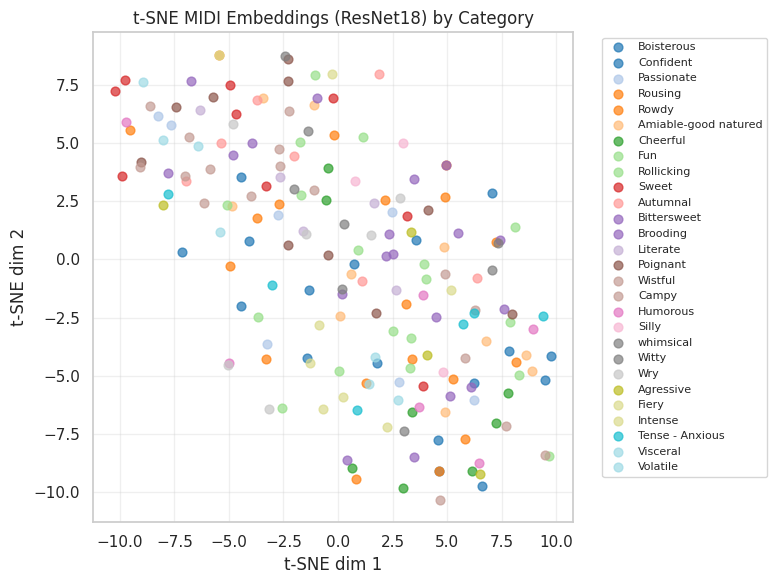

In [10]:
resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
resnet18.conv1 = nn.Conv2d(
    1,
    resnet18.conv1.out_channels,
    kernel_size=resnet18.conv1.kernel_size,
    stride=resnet18.conv1.stride,
    padding=resnet18.conv1.padding,
    bias=False
)
resnet18.fc = nn.Identity()
resnet18 = resnet18.to(device)
resnet18.eval()
print("✓ ResNet18 ready for MIDI embeddings")

midi_transform = T.Compose([
    T.ToTensor(),            # (H, W) → [1, H, W]
    T.Resize((224, 224)),
    T.Normalize(mean=[0.5], std=[0.5])
])

def midi_to_pianoroll(path, fs=10, max_length=1000):
    pm = pretty_midi.PrettyMIDI(path)
    roll = pm.get_piano_roll(fs=fs)       # [128, T]
    roll = (roll > 0).astype(np.float32)
    if roll.shape[1] > max_length:
        roll = roll[:, :max_length]
    else:
        pad = max_length - roll.shape[1]
        roll = np.pad(roll, ((0, 0), (0, pad)), mode="constant")
    return roll

def extract_midi_embedding(path):
    roll = midi_to_pianoroll(path)
    img = midi_transform(roll)            # [1, H, W]
    img = img.unsqueeze(0).to(device)     # [1, 1, H, W]
    with torch.no_grad():
        emb = resnet18(img)               # [1, 512]
    return emb.squeeze(0).cpu().numpy()

midi_emb_records = []
for f in tqdm(midi_files, desc="Extracting MIDI embeddings"):
    file_id = os.path.splitext(f)[0]
    if file_id in corrupt_midi:
        continue
    path = os.path.join(midi_dir, f)
    try:
        vec = extract_midi_embedding(path)
        row = {"file_id": file_id}
        for i, v in enumerate(vec):
            row[f"midi_emb_{i}"] = float(v)
        midi_emb_records.append(row)
    except Exception as e:
        print("Error embedding MIDI", f, ":", e)

midi_emb_df = pd.DataFrame(midi_emb_records)
print("MIDI embeddings shape:", midi_emb_df.shape)

midi_full = (
    midi_stats_df
      .merge(midi_emb_df, on="file_id", how="inner")
      .merge(labels_df, on="file_id", how="left")
)
print("MIDI + labels:", midi_full.shape)
display(midi_full.head())

midi_emb_cols = [c for c in midi_full.columns if c.startswith("midi_emb_")]
X_midi = midi_full[midi_emb_cols].values
y_midi = midi_full["category"].fillna("Unknown")

midi_tsne = tsne_and_scatter(
    X_midi, y_midi,
    title="t-SNE MIDI Embeddings (ResNet18) by Category"
)

Visualisasi t-SNE pada embedding MIDI menunjukkan sebaran titik yang sangat acak tanpa pola clustering yang berarti. Variabilitas durasi dan jumlah track MIDI yang tinggi serta jumlah data yang lebih sedikit membuat modalitas ini kurang mampu menghasilkan representasi yang terpisah antar kategori.

## Inter-Modal (Korelasi Fitur Mentah)

Merged raw features shape: (191, 14)


,file_id,duration_audio,tempo,zcr,spectral_centroid,rms_energy,word_count,line_count,avg_word_length,duration_midi,pitch_range,avg_velocity,category,cluster
0,004,29.675102,[95.703125],0.088290,2967.550972,0.173973,232,52,3.758621,230.458718,63,117.386846,Boisterous,Cluster 1
1,008,29.675102,[114.84375],0.087663,3256.528882,0.279501,122,18,4.098361,267.857000,33,126.945980,Boisterous,Cluster 1
2,012,29.675102,[92.28515625],0.115414,4149.681641,0.101903,393,47,3.798982,280.470035,56,91.172080,Boisterous,Cluster 1
3,019,29.767982,[139.6748310810811],0.062891,2363.916372,0.113394,249,37,4.156627,249.595000,60,113.399088,Boisterous,Cluster 1
4,020,29.675102,[143.5546875],0.078374,2703.798661,0.129200,112,13,4.482143,138.923494,92,105.848546,Boisterous,Cluster 1


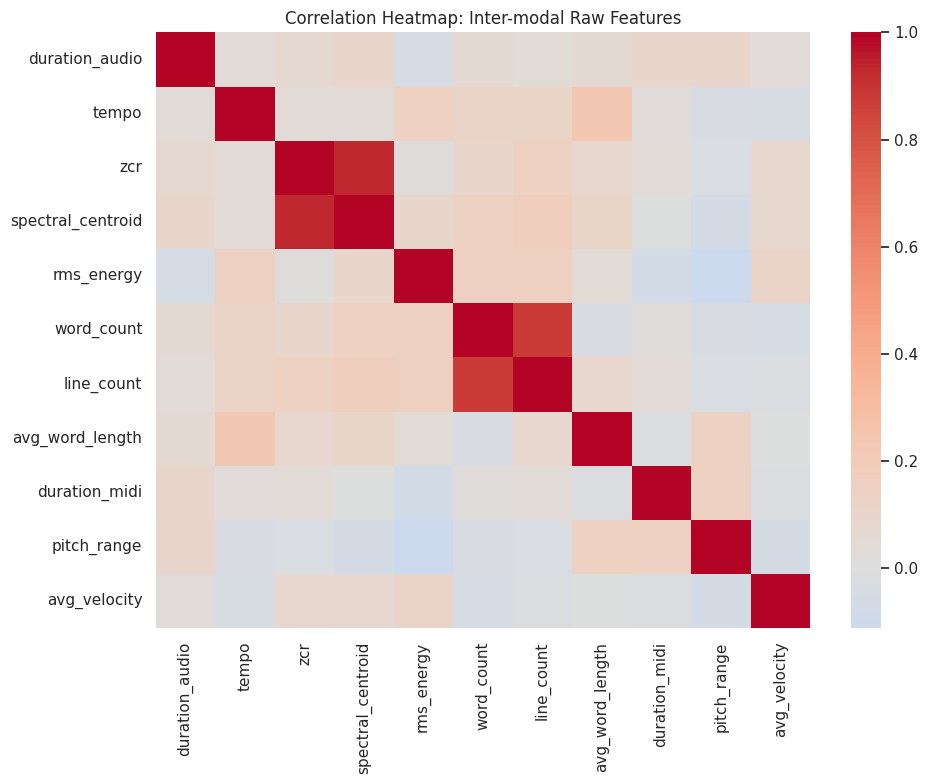

Rata-rata fitur per kategori:


,duration_audio,tempo,zcr,spectral_centroid,rms_energy,word_count,line_count,avg_word_length,duration_midi,pitch_range,avg_velocity
category,,,,,,,,,,,
Agressive,29.535782,[126.58852025082237],0.069666,2558.311877,0.105808,194.000000,34.250000,4.072424,157.608058,54.750000,95.225554
Amiable-good natured,29.331447,[116.53144013618153],0.068020,2695.914878,0.129581,222.600000,37.200000,4.027249,183.915305,62.100000,90.327199
Autumnal,29.708273,[125.22210686273186],0.049908,2045.174740,0.102691,167.000000,26.000000,3.889360,357.368632,58.285714,88.371940
Bittersweet,29.606498,[111.1428049521394],0.050098,2062.446622,0.104438,166.090909,26.909091,4.068789,209.617504,61.000000,91.471503
Boisterous,29.693678,[117.21230996621621],0.086527,3088.295306,0.159594,221.600000,33.400000,4.058947,233.460849,60.800000,110.950508
Brooding,29.650431,[127.38478630557768],0.049753,2281.224215,0.156302,177.375000,25.625000,4.034954,251.241752,49.250000,91.791742
Campy,29.684390,[127.0932966239579],0.065661,2488.613840,0.127535,395.400000,63.800000,4.233239,201.464354,58.600000,91.862509
Cheerful,29.605442,[103.80870015458156],0.086243,3260.464828,0.106527,239.000000,40.625000,3.927257,220.914899,62.625000,96.656964
Confident,29.639305,[133.115053877699],0.082025,2954.699400,0.146266,263.916667,41.583333,4.010486,229.966853,61.250000,99.634196


In [15]:
merged_raw = (
    audio_stats_df[["file_id", "duration_audio", "tempo", "zcr",
                    "spectral_centroid", "rms_energy"]]
      .merge(lyrics_stats_df[["file_id", "word_count", "line_count",
                              "avg_word_length"]], on="file_id", how="inner")
      .merge(midi_stats_df[["file_id", "duration_midi", "pitch_range",
                            "avg_velocity"]], on="file_id", how="inner")
      .merge(labels_df[["file_id", "category", "cluster"]], on="file_id", how="left")
)

print("Merged raw features shape:", merged_raw.shape)
display(merged_raw.head())

feature_cols = [
    "duration_audio", "tempo", "zcr", "spectral_centroid", "rms_energy",
    "word_count", "line_count", "avg_word_length",
    "duration_midi", "pitch_range", "avg_velocity"
]

corr = merged_raw[feature_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap: Inter-modal Raw Features")
plt.tight_layout()
plt.show()

print("Rata-rata fitur per kategori:")
display(merged_raw.groupby("category")[feature_cols].mean())

Visualisasi correlation heatmap menunjukkan bahwa korelasi antar fitur yang berbeda modalitas sangat rendah.

Fitur dalam modalitas yang sama menunjukkan korelasi cukup tinggi, seperti:

- word_count dan line_count,

- spectral_centroid dan ZCR,

- pitch_range dan duration_midi,

Namun korelasi lintas modalitas sebagian besar masih rendah, yang berarti hubungan hampir tidak ada.

## t-SNE Gabungan 3 Modalitas

Combined embeddings shape: (191, 3330)


,file_id,audio_emb_0,audio_emb_1,audio_emb_2,audio_emb_3,audio_emb_4,audio_emb_5,audio_emb_6,audio_emb_7,audio_emb_8,...,midi_emb_503,midi_emb_504,midi_emb_505,midi_emb_506,midi_emb_507,midi_emb_508,midi_emb_509,midi_emb_510,midi_emb_511,category
0,004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.408567,0.0,0.440808,2.438327,1.115871,0.264604,1.542620,0.332262,0.048029,Boisterous
1,008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.580689,0.0,0.329122,2.388682,1.199804,0.085526,2.059542,0.376692,0.092912,Boisterous
2,012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.464552,0.0,0.453686,1.120349,1.094212,0.455733,1.102295,0.680130,0.064255,Boisterous
3,019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.344459,0.0,0.503255,2.284739,1.668405,0.247653,1.699627,0.285931,0.000000,Boisterous
4,020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.662778,0.0,0.371331,2.096544,0.874402,0.117971,0.916586,0.287495,0.007363,Boisterous


Running t-SNE: n_samples=191, dim=3328, perplexity=30


/tmp/ipython-input-782246349.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(uniq))


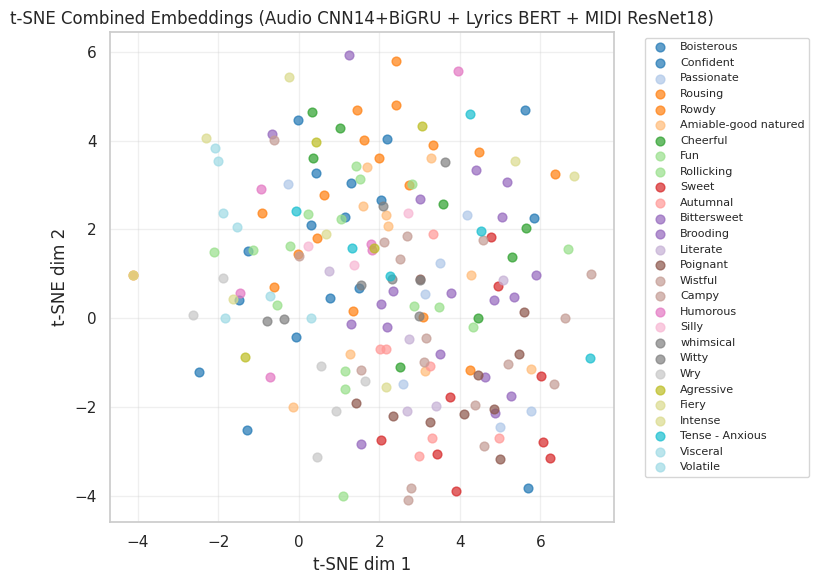

In [14]:
audio_emb_small  = audio_full[["file_id"] + [c for c in audio_full.columns if c.startswith("audio_emb_")]]
lyrics_emb_small = lyrics_full[["file_id"] + [c for c in lyrics_full.columns if c.startswith("lyrics_emb_")]]
midi_emb_small   = midi_full[["file_id"] + [c for c in midi_full.columns if c.startswith("midi_emb_")]]

combined = (
    audio_emb_small
      .merge(lyrics_emb_small, on="file_id", how="inner")
      .merge(midi_emb_small, on="file_id", how="inner")
      .merge(labels_df[["file_id", "category"]], on="file_id", how="left")
)

print("Combined embeddings shape:", combined.shape)
display(combined.head())

if combined.empty:
    print("Tidak ada sampel dengan tiga modalitas lengkap.")
else:
    audio_cols  = [c for c in combined.columns if c.startswith("audio_emb_")]
    lyrics_cols = [c for c in combined.columns if c.startswith("lyrics_emb_")]
    midi_cols   = [c for c in combined.columns if c.startswith("midi_emb_")]

    X_audio_z  = zscore_np(combined[audio_cols].values)
    X_lyrics_z = zscore_np(combined[lyrics_cols].values)
    X_midi_z   = zscore_np(combined[midi_cols].values)

    X_mm = np.concatenate([X_audio_z, X_lyrics_z, X_midi_z], axis=1)
    y_mm = combined["category"].fillna("Unknown")

    mm_tsne = tsne_and_scatter(
        X_mm, y_mm,
        title="t-SNE Combined Embeddings (Audio CNN14+BiGRU + Lyrics BERT + MIDI ResNet18)"
    )

Ketika embedding dari ketiga modalitas digabungkan, t-SNE masih memperlihatkan tumpang-tindih antar kategori. Hal ini menegaskan bahwa tugas klasifikasi emosi musik memang kompleks dan tidak mudah dipisahkan secara linear.

## Kesimpulan

### Audio
Hasil EDA menunjukkan bahwa modalitas audio memiliki kualitas yang paling stabil, terutama karena seluruh file berdurasi hampir seragam di sekitar 30 detik. Oleh sebab itu, preprocessing audio dilakukan dengan men-standardisasi panjang sinyal menjadi tepat 30 detik melalui proses trim atau padding, lalu mengekstraknya menggunakan PANNs CNN14 pretrained. Fitur manual seperti tempo tidak digunakan karena terbukti sangat tidak stabil pada EDA, sedangkan CNN14 sudah mampu menangkap pola ritmis dan spektral secara otomatis dari waveform. Embedding 2048-dim dari CNN14 menjadi representasi akhir untuk modalitas audio.

### Lirik
Pada modalitas lirik, variasi panjang teks cukup besar, namun struktur penulisan secara umum baik. Strategi preprocessing dilakukan dengan pembersihan ringan dan tokenisasi menggunakan BERT dengan batas panjang tertentu (256–384 token) untuk mengatasi lirik yang sangat panjang. Embedding diperoleh melalui mean pooling pada hidden state terakhir, menghasilkan representasi 768-dim yang telah mengandung informasi semantik tanpa perlu fitur manual tambahan.

### Midi
Modalitas MIDI memiliki variabilitas paling besar, terutama dari sisi durasi dan jumlah track. Untuk menyejajarkan dengan audio, setiap file MIDI diambil window 30 detik kemudian dikonversi menjadi piano-roll biner. Piano-roll tersebut di-resize ke 224×224 agar sesuai dengan arsitektur ResNet18 pretrained yang digunakan sebagai feature extractor. Hasil ekstraksi berupa embedding 512-dim yang mewakili pola harmonis dan ritmis utama dari bagian lagu tersebut.

### Late Fusion
Karena EDA menunjukkan bahwa ketiga modalitas tidak berkorelasi kuat dan tidak mampu memisahkan kategori secara individu (t-SNE menunjukkan overlap tinggi), digunakan pendekatan late fusion. Embedding dari setiap modalitas dinormalisasi menggunakan z-score, lalu digabungkan melalui late fusion sebelum dimasukkan ke MLP classifier. Pendekatan ini memungkinkan tiap modalitas berkontribusi sesuai kekuatannya, sekaligus memanfaatkan sifat komplementer antar-modalitas.